In [34]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns


from sklearn.neighbors import NearestNeighbors


# The settings used for the KNN analysis
args = {'n_neighbors':100,
        'dist_metric':'cosine',
        'dist_algorithm':'auto', # algorithm used for calculating the distances. Should not affect outcomes, only computational complexity
        'n_jobs':10,
        'sim_score_method':'Intersect'}
TOTAL_ENTITIES = 178722
# TOTAL_ENTITIES = 132
n_samples = int(TOTAL_ENTITIES*0.1) # Number of samples taken for the nearest neighbor calculation is set to be 5% from the total number of entities
print(n_samples)

17872


# Initializing functions for determining the similarity between two embeddings.

In [14]:
def det_KNN(samples, embed, args):
    model = NearestNeighbors(n_neighbors=args['n_neighbors'],
                         metric=args['dist_metric'],
                         algorithm=args['dist_algorithm'],
                         n_jobs=args['n_jobs']).fit(embed)
    _, indices = model.kneighbors(samples)
    return [set(i) for i in indices]

def calc_jaccard(set1, set2):
    return len(set1.intersection(set2))/len(set1.union(set2))

def calc_intersect(set1, set2):
    return len(set1.intersection(set2))

def detect_bin_change(target_sample, nn_set):
    '''
    :param target_sample: Should be a
    :param nn_set:
    :return:
    '''
    max_similarity = 0
    most_similar_set = None

    for current_set in nn_set:
        similarity = len(current_set[1].intersection(target_sample[1]))
        if current_set[0] == target_sample[0]:
            print(f"Similarity of entity with label(s) {current_set[0]}: {similarity}")
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_set = current_set
    print(f'Max similarity with entity with label(s) {most_similar_set[0]}: {max_similarity} \n')
    return target_sample[0] == most_similar_set[0]

def det_similarity(embed1, embed2, labels):
    idx = np.random.choice(np.arange(len(embed1)), n_samples, replace=False)
    embed1_sample = embed1.loc[idx]
    embed2_sample = embed2.loc[idx]

    # labels = embed1_sample['label']

    print(len(embed1_sample))
    KNN1 = det_KNN(embed1_sample.to_numpy(), embed1.to_numpy(), args)
    KNN2 = det_KNN(embed2_sample.to_numpy(), embed2.to_numpy(), args)

    if args['sim_score_method'] == 'Jaccard':
        jaccard_scores = [calc_jaccard(nn1, nn2) for nn1, nn2 in zip(KNN1, KNN2)]
        return jaccard_scores

    elif args['sim_score_method'] == 'Intersect':
        intersect_scores = [calc_intersect(nn1, nn2) for nn1, nn2 in zip(KNN1, KNN2)]
        return intersect_scores

    elif args['sim_score_method'] == 'Binary_change':
        bin_change_scores = [detect_bin_change(nn, zip(labels, KNN2)) for nn in zip(labels, KNN1)]
        return bin_change_scores
    else:
        raise Exception(f'Unknown similarity score: {args["sim_score_method"]}')


# Comparing the embeddings with of the tax_NCIT graph with the embeddings of the tax_and_subset_NCIT graph

In [26]:
def det_combinations(n_reps):
    combs = [(i, j) for i in range(n_reps) for j in range(i, n_reps) if i != j]
    return combs


def det_label(kg_name):
    if kg_name == 'tax_and_subset_NCIT':
        return 'tax+subset'
    elif kg_name == 'tax_NCIT':
        return 'tax'
    elif 'pizza' in kg_name:
        return 'pizza'
    else:
        raise NotImplementedError(f'Unknown knowledge graph: "{kg_name}"')

def get_embed_location(root_dir, epoch, run):
    return f'./data/embeddings/{root_dir}/{str(epoch)}_{str(run)}.pkl'

def make_violin_plot(epochs_list, combinations, embedding_dir1, embedding_dir2):
    mean_df = pd.DataFrame()
    plt.figure(figsize=(4,3))
    for comb in combinations:
        sim_scores_df = pd.DataFrame()
        for epochs in epochs_list:
            kg1 = embedding_dir1.split('/')[-1]
            print(f'determining the similarity between run {comb[0]} and {comb[1]} for {epochs} epochs of KG "{kg1}"')
            sim_scores_1 = compare_embedding(get_embed_location(embedding_dir1, epochs, comb[0]), get_embed_location(embedding_dir1, epochs, comb[1]))
            sim_scores_1['epoch'] = epochs
            sim_scores_1['KG'] = embedding_dir1.split('/')[-1]

            kg2 = embedding_dir2.split('/')[-1]
            print(f'determining the similarity between run {comb[0]} and {comb[1]} for {epochs} epochs of KG "{kg2}"')
            sim_scores_2 = compare_embedding(get_embed_location(embedding_dir2, epochs, comb[0]), get_embed_location(embedding_dir2, epochs, comb[1]))
            sim_scores_2['epoch'] = epochs
            sim_scores_2['KG'] = embedding_dir2.split('/')[-1]
            sim_scores_df = pd.concat([sim_scores_df, sim_scores_1, sim_scores_2])
        ax = sns.violinplot(data=sim_scores_df, x='sim_scores', y='epoch', orient='h',
                            inner=None, hue="KG", hue_order=[embedding_dir2.split('/')[-1], embedding_dir1.split('/')[-1]],  split=True)
        ax.invert_yaxis()
        for violin in ax.collections:
            violin.set_alpha(0.1)

        mean = sim_scores_df.groupby(['epoch' ,'KG']).mean()
        print(mean)
        mean['order'] = [i for i in range(len(epochs_list)) for _ in range(2)]
        mean['comb'] = str(comb)*len(epochs_list)*2
        mean_df = pd.concat([mean_df, mean])

    ax = sns.scatterplot(data=mean_df, y = 'order', x='sim_scores', hue='KG', hue_order=[embedding_dir2.split('/')[-1], embedding_dir1.split('/')[-1]], marker='X')
    handles, labels  =  ax.get_legend_handles_labels()
    grey_cross = mlines.Line2D([], [], color='grey', marker='X', linestyle='None',
                          markersize=5)
    legend = ax.legend([handles[-2],  grey_cross,  handles[-1]], [det_label(labels[-2]), 'mean', det_label(labels[-1])],
              title='KG', loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.55))

    plt.ylabel('Training epochs')
    plt.xlabel('Similarity score')
    plt.show()
    return mean_df

def compare_embedding(loc_embed_1, loc_embed_2):
    embeddings1 = pd.read_pickle(loc_embed_1)
    embeddings2 = pd.read_pickle(loc_embed_2)
    for i in range(len(embeddings1['label'])):
        if embeddings1['IRI'].loc[i] != embeddings2['IRI'].loc[i]:
            print(f'Inconsistent labeling: {embeddings1["label"].loc[i]} - {embeddings2["label"].loc[i]} at index {i}')
    assert (embeddings1['IRI'].equals(embeddings2['IRI'])), "all IRIs should match"
    labels = embeddings1['label']

    sim_scores = det_similarity(embeddings1.drop(['label', 'IRI'], axis=1), embeddings2.drop(['label', 'IRI'], axis=1), labels)
    sim_scores_df = pd.DataFrame({'sim_scores':sim_scores})
    return sim_scores_df

determining the similarity between run 0 and 1 for 10 epochs of KG "tax_subset_label_NCIT"
17872
determining the similarity between run 0 and 1 for 10 epochs of KG "tax_subset_label_NCIT"
17872
determining the similarity between run 0 and 1 for 20 epochs of KG "tax_subset_label_NCIT"
17872
determining the similarity between run 0 and 1 for 20 epochs of KG "tax_subset_label_NCIT"
17872
                             sim_scores
epoch KG                               
10    tax_subset_label_NCIT    1.363250
20    tax_subset_label_NCIT    1.313255


ValueError: Length of values (4) does not match length of index (2)

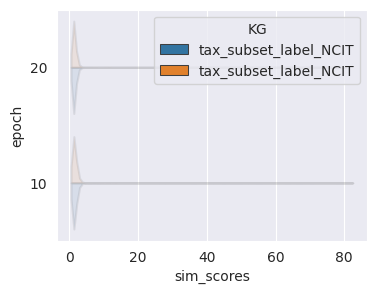

In [37]:
# WARNING: running this line takes approximantly 4 hours when comparing 5% of all entities
mean_sim_scores = make_violin_plot([10, 20], det_combinations(2), 'tax_subset_label_NCIT', 'tax_subset_label_NCIT')

In [5]:
grouped_scores = mean_sim_scores.drop(['order'], axis=1).groupby(['epoch', 'KG'])
mu_scores = grouped_scores.mean('sim_scores')
mu_scores['std'] = grouped_scores.std(numeric_only=True).sim_scores

In [6]:
print(mu_scores)

              sim_scores       std
epoch KG                          
25    pizza        76.31  0.981439
      pizza2       76.46  0.625744
100   pizza        76.31  1.577234
      pizza2       76.53  1.963019
200   pizza        75.83  0.713442
      pizza2       75.84  0.689928
500   pizza        75.74  0.939503
      pizza2       75.16  0.554176


# Calculating ERI

In [5]:
def calc_ERI(embed1, embed2, mu_hat, jaccard=1):
    mean_sim_score = compare_embedding(embed1, embed2).mean()
    print(mean_sim_score[0])
    return min(mean_sim_score[0]/mu_hat, 1) * jaccard

def conduct_rank_experiment(rank_list, graph_name, training_epochs, original_runs, mod_runs, mu_hat_dict = None):
    results = pd.DataFrame()
    for rank_comparison in rank_list:
        print(f'determining ERI for rank {rank_comparison}')
        rank_df = pd.DataFrame()
        for mod_run in range(mod_runs):
            mod_graph_embedding = get_embed_location(f'modified_graphs/{graph_name}/{rank_comparison}', training_epochs, mod_run)
            for original_run in range(original_runs):
                origin_graph_embedding = get_embed_location(graph_name, training_epochs, original_run)
                if mu_hat_dict == None:
                    mu_hat = mu_scores.loc[(training_epochs, graph_name)].sim_scores
                else:
                    mu_hat = mu_hat_dict[graph_name]
                # print(mu_hat)
                ERI_score = pd.DataFrame({'ERI': [calc_ERI(mod_graph_embedding, origin_graph_embedding, mu_hat)], 'comparison': f'{(mod_run, original_run)}'})
                # ERI_score['comparison'] = f'{(mod_run, original_run)}'
                rank_df = pd.concat([rank_df, ERI_score])
        rank_df['rank'] = rank_comparison
        print(rank_df.ERI.mean())
        results = pd.concat([results, rank_df])
    results['training_epochs'] = training_epochs
    return results



In [12]:
rank_list = [f'rank_{i+1}_to_{i}' for i in range(1,15)]

# WARNING: running this line takes approximantly 4 hours when comparing 5% of all entities
results = conduct_rank_experiment(rank_list, 'tax_NCIT', 100, 5, 1, {'tax_NCIT':60.30})

determining ERI for rank rank_2_to_1
1787
1.054840514829323
1787
1.0587576944599888
1787
1.0621152770005595
1787
1.0649132624510353
1787
1.0498041410184666
0.017547034460230097
determining ERI for rank rank_3_to_2
1787
1.0503637381085618
1787
1.059876888640179
1787
1.0705092333519866
1787
1.0710688304420817
1787
1.0542809177392278
0.01759900367589399
determining ERI for rank rank_4_to_3
1787
1.0604364857302742
1787
1.0570789031897034
1787
1.0621152770005595
1787
1.0604364857302742
1787
1.059876888640179
0.017578587198311745
determining ERI for rank rank_5_to_4
1787
1.0615556799104644
1787
1.0643536653609402
1787
1.0626748740906546
1787
1.0542809177392278
1787
1.0755456071628426
0.017639836631058472
determining ERI for rank rank_6_to_5
1787
1.0671516508114158
1787
1.0671516508114158
1787
1.0621152770005595
1787
1.0699496362618914
1787
1.0609960828203693
0.017669533325723553
determining ERI for rank rank_7_to_6
1787
1.0654728595411305
1787
1.0649132624510353
1787
1.0604364857302742
1787


# Creating the figure of the mean ERI

/tmp/ipykernel_6346/2611186797.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{l.get_text().split("_")[1]} to {l.get_text().split("_")[3]}' for l in ax.get_xticklabels()])


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '2 to 1'),
  Text(1, 0, '3 to 2'),
  Text(2, 0, '4 to 3'),
  Text(3, 0, '5 to 4'),
  Text(4, 0, '6 to 5'),
  Text(5, 0, '7 to 6'),
  Text(6, 0, '8 to 7'),
  Text(7, 0, '9 to 8'),
  Text(8, 0, '10 to 9'),
  Text(9, 0, '11 to 10'),
  Text(10, 0, '12 to 11'),
  Text(11, 0, '13 to 12'),
  Text(12, 0, '14 to 13'),
  Text(13, 0, '15 to 14')])

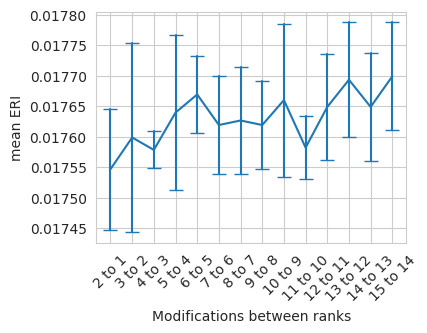

In [15]:

plt.figure(figsize=(4,3))
grouped_results = results.groupby(['rank'])
ERI_scores = grouped_results.mean('ERI')
ERI_scores['std'] = grouped_results.std(numeric_only=True).ERI


ax = sns.lineplot(data=results, x='rank', y='ERI', errorbar='sd', err_style='bars', err_kws={'capsize':5})

ax.set_xticklabels([f'{l.get_text().split("_")[1]} to {l.get_text().split("_")[3]}' for l in ax.get_xticklabels()])
ax.set_xlabel('Modifications between ranks')
ax.set_ylabel('mean ERI')
plt.xticks(rotation=45)

# Comparing loss function


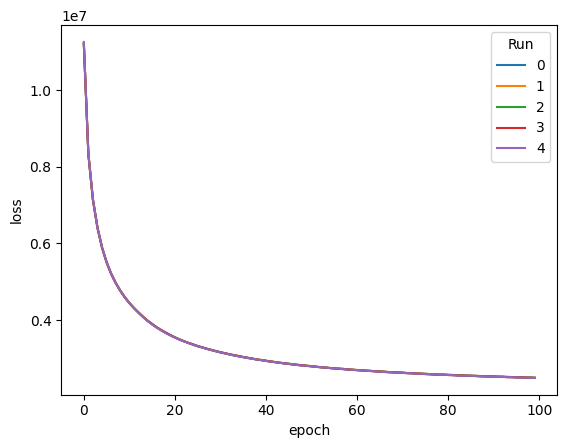

In [176]:
loss_df = pd.DataFrame()

n_runs = 5

for r in range(n_runs):
    df = pd.read_pickle(f'./data/loss_data/tax_and_subset_NCIT/{str(r)}.pkl')
    df['run'] = str(r)*len(df)
    loss_df = pd.concat([loss_df, df])

ax = sns.lineplot(loss_df, x='epoch', y='loss', hue='run')
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, range(n_runs), title='Run')